In [4]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import numpy as np
%matplotlib inline
#plt.style.use('Solarize_Light2')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()


In [5]:
cov = cov = pd.read_csv('new_datav2.csv')

In [6]:
cov.tail()

,Unnamed: 0,date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
397,397,2021-02-22,55617,101285,112094,10712,20548,614,2069751,170506,...,4138237,53310,79681,1,136545,2392,174969,2176,75027,35862
398,398,2021-02-23,55646,102306,112279,10739,20584,636,2077228,170672,...,4146760,53973,79717,1,136986,2403,176377,2187,75582,35910
399,399,2021-02-24,55664,103327,112461,10775,20640,646,2085411,170945,...,4156707,54874,79749,1,137445,2412,177768,2221,76484,35960
400,400,2021-02-25,55680,104313,112622,10799,20695,701,2093645,171227,...,4166727,55695,79773,1,137871,2421,179293,2255,77171,35994
401,401,2021-02-26,55696,105229,112805,10822,20759,701,2098728,171510,...,4175315,56542,79804,1,138295,2426,180848,2267,77639,36044


In [7]:
y=cov['Senegal']

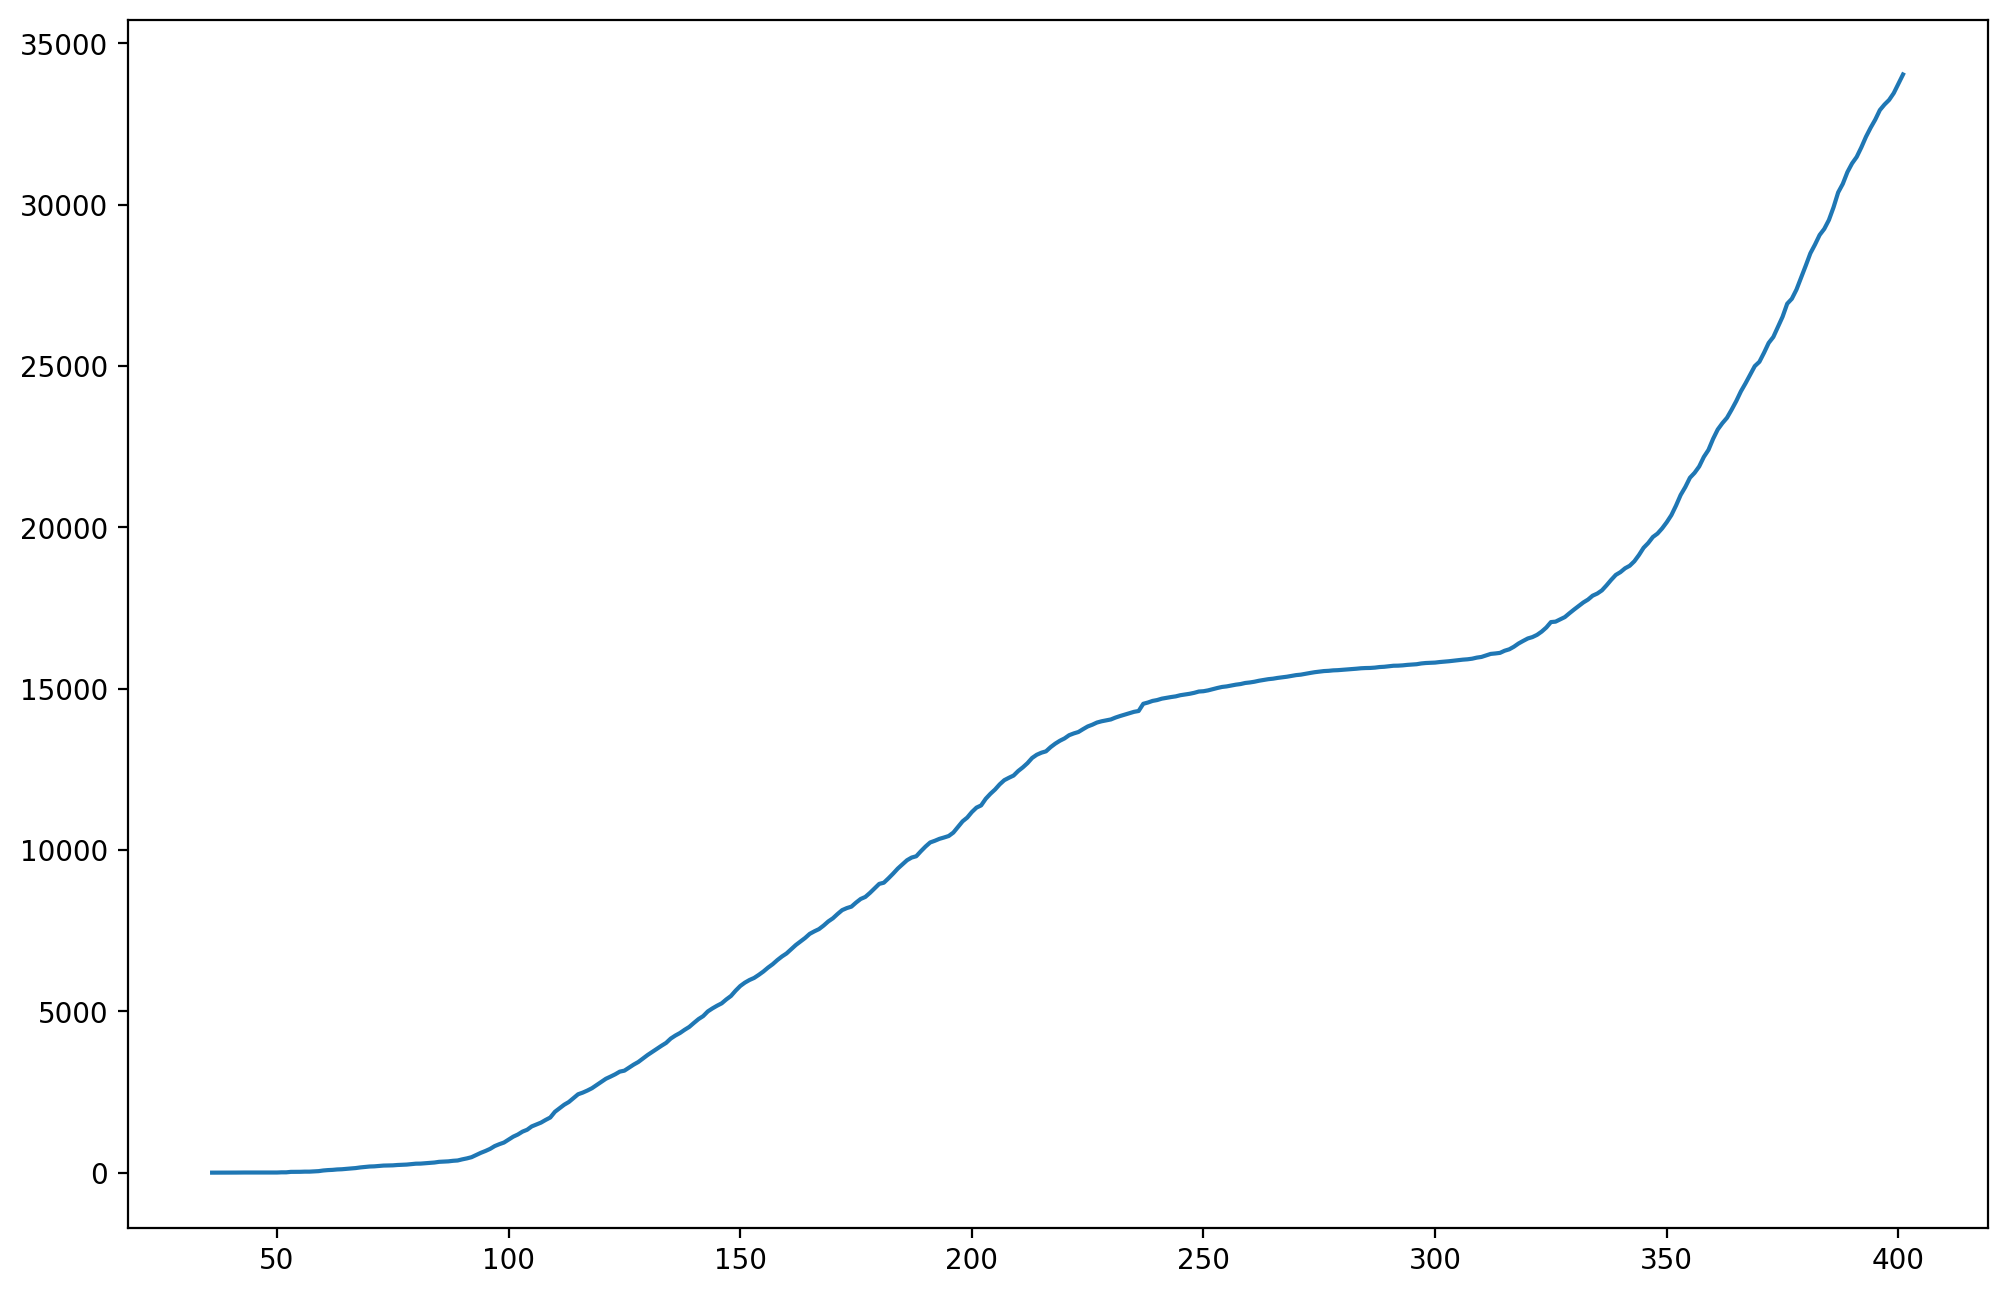

In [8]:
plt.figure(figsize=(12,8),dpi=200)
plt.plot(cov['Senegal'][36:], label="Cases")
plt.show ()


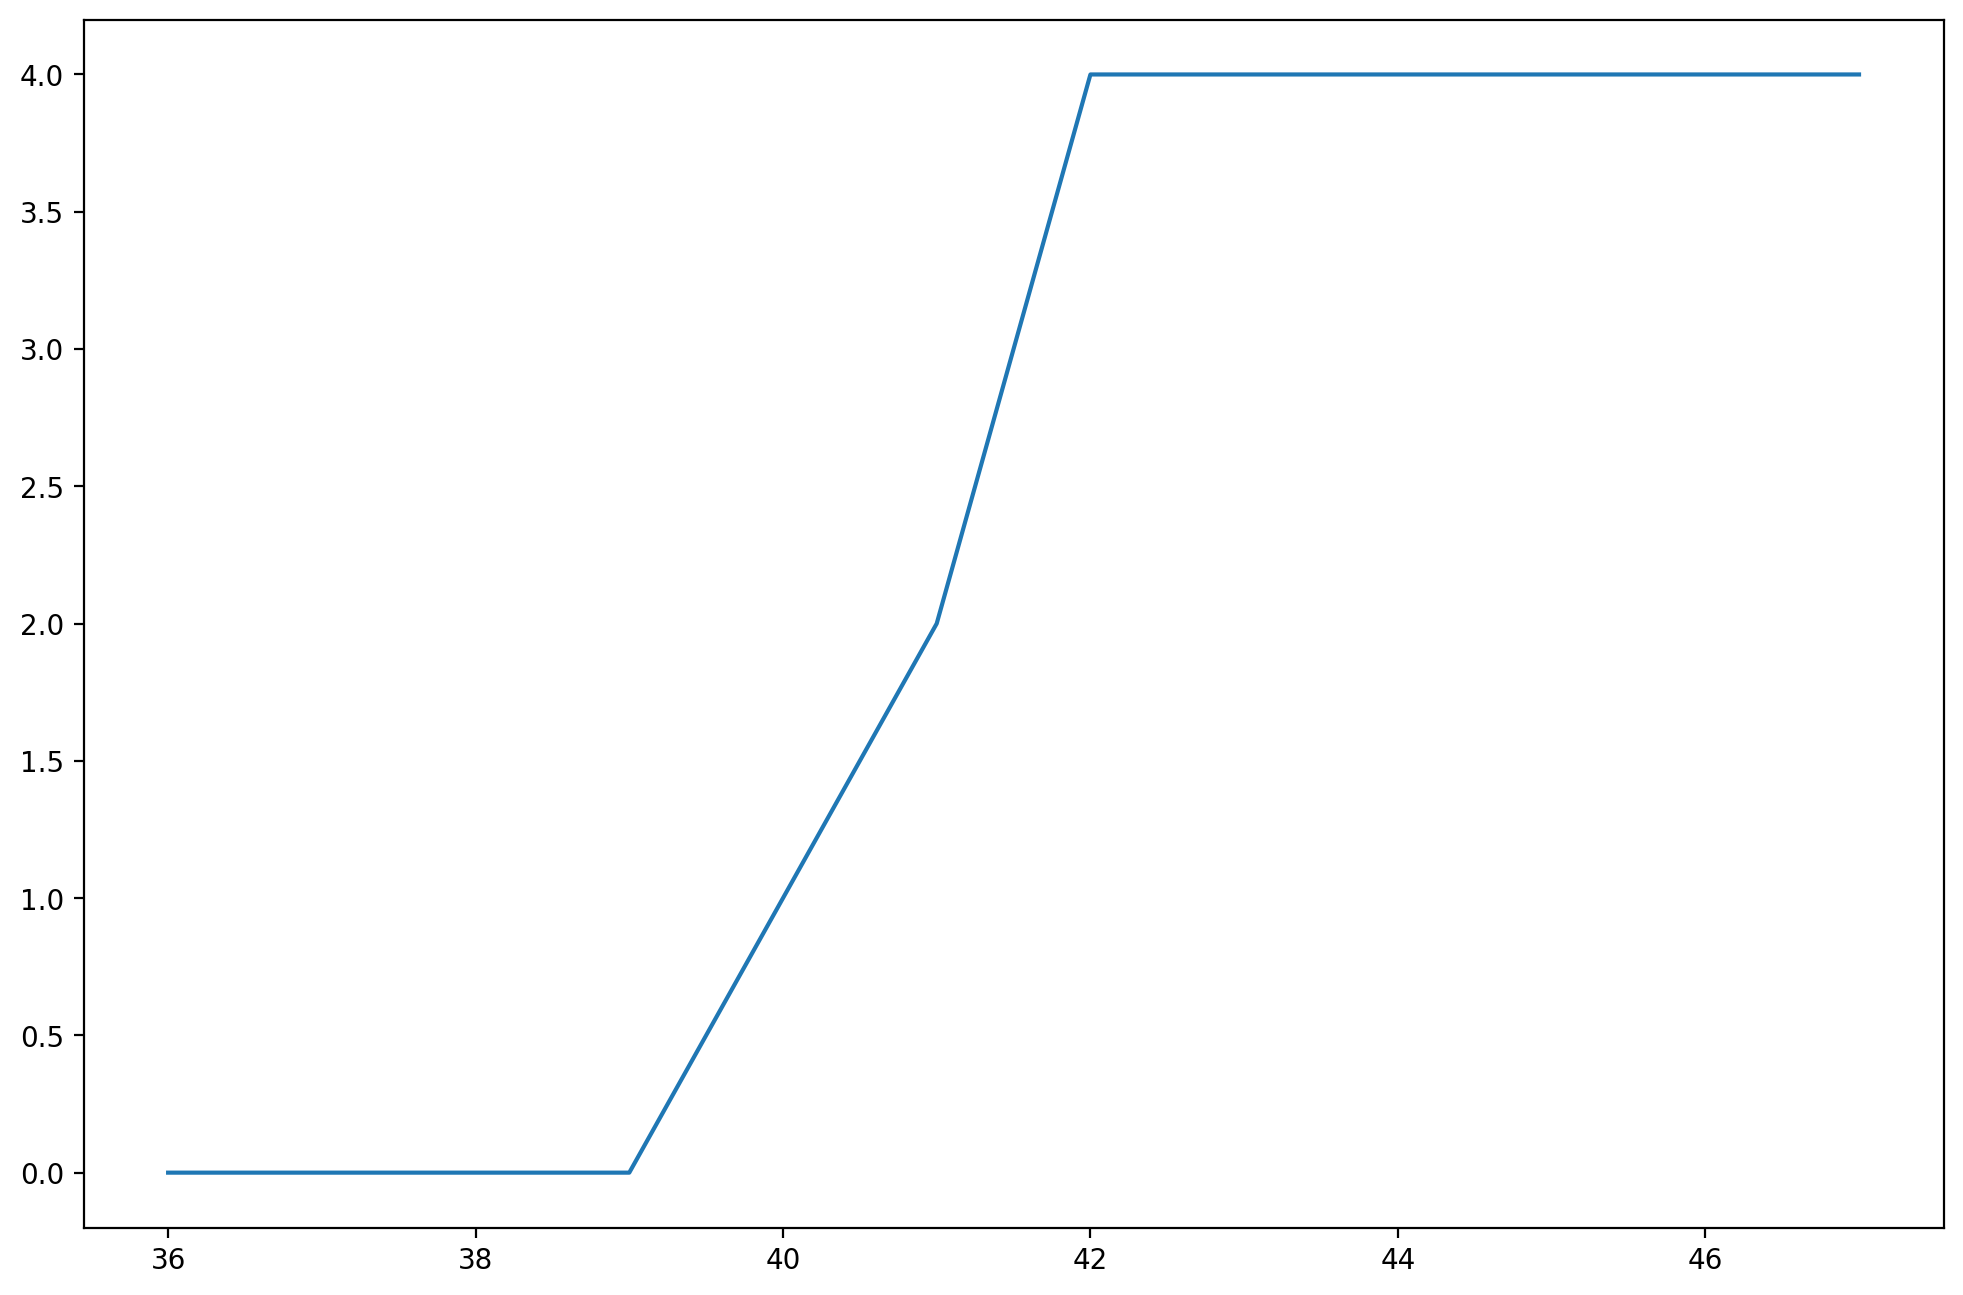

In [9]:
plt.figure(figsize=(12,8),dpi=200)
plt.plot(cov['Senegal'][36:48], label="Cases")
plt.show ()

##  Simulation avec la fonction $ f(t)=bt.ln(1+at)$

In [10]:
# Définition de la fonction 𝑓(𝑡)=𝑏𝑡.𝑙𝑛(1+𝑎𝑡)
import numpy as np
def func_ln(a,b,t):
    y=a*t*np.log(1+b*t)
    return  y

## Estimation des valeurs de a et b
Nous pensons que les coefficients a et b prennent des valeurs comprises entre 0 et 1. Ainsi pour trouver les meilleurs 
valeurs de a et b  nous avons essayé tous le valeurs comprises entre 0 et 1 avec un pas de 0.1.
Pour la suite nous uiliserons le couple (a,b) qui retourne le plus petit MSE


In [11]:
data=cov['Senegal'][36:].reset_index()

data1=data['Senegal'][0:13]
data2=data['Senegal'][13:]
temps=data1.index
from sklearn.metrics import mean_squared_error
value_poss=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
mse_list=[]
params=[]
for i in value_poss:
    for j in value_poss:
        predict=func_ln(i,j,temps)
        error = mean_squared_error(data1, predict)
        mse_list.append(error)
        params.append((i,j))
ind=mse_list.index(min(mse_list))
print(mse_list[ind],params[ind])
#print('Le MSE minimal est {0} et les valeur de a et b correspondantes sont {1}'.format(mse_list[ind],params[ind]))

tmp=mse_list.copy()
tmp.sort()
for i in tmp[:10]:
    ind = mse_list.index(i)
    x = params[ind]
    print(x,i)


0.8359358146598641 (0.2, 0.7)
(0.2, 0.7) 0.8359358146598641
(0.2, 0.8) 0.8421423479644522
(0.2, 0.6) 0.892623582987524
(0.2, 0.9) 0.8926330332908816
(0.3, 0.3) 0.9481707212977315
(0.4, 0.2) 1.0391196572839856
(0.2, 0.5) 1.0415783496185513
(0.3, 0.4) 1.1019337090719572
(0.6, 0.1) 1.131192775610887
(0.2, 0.4) 1.3320478933351403


In [12]:
len(mse_list)

81

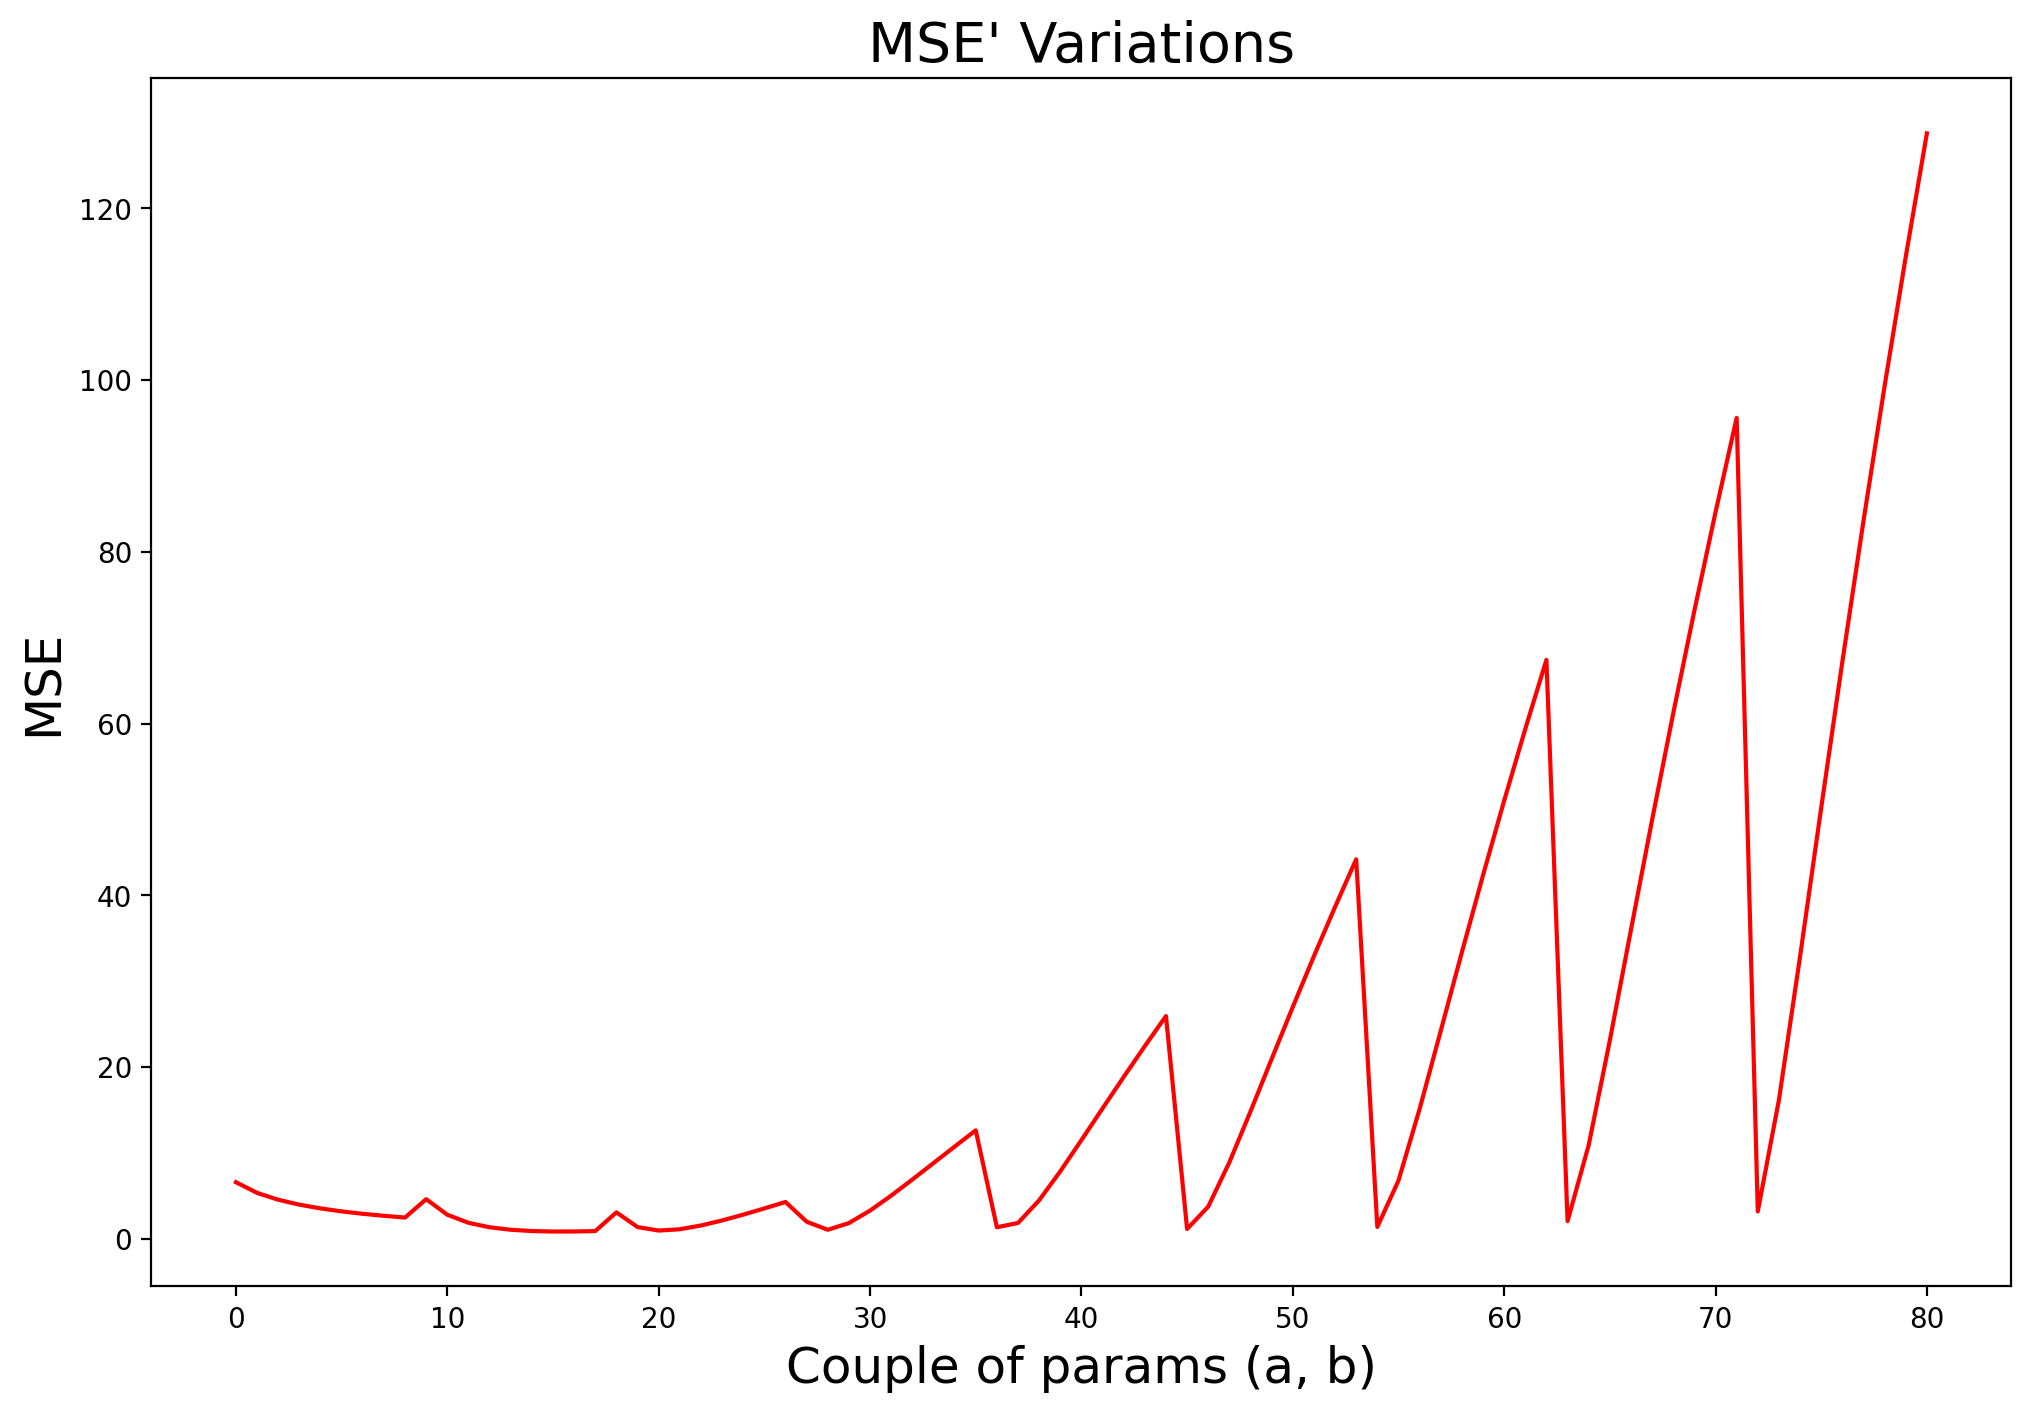

In [13]:
plt.figure(figsize=(12,8),dpi=200)
plt.plot(range(len(mse_list)), mse_list, 'r')
plt.xlabel("Couple of params (a, b)", fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.title("MSE' Variations", fontsize=20)
plt.savefig("mse_fonction_ln.jpg")

## Prédiction avec la fonction $ f(t)=0.9t.ln(1+0.2t)$
Nous appliquons la fonctions avec les valeurs de a et b trouver ci dessus enrtre les dates   $28/02/2020$(index=0) et $11/03/2020$(index=12).

Le résultat est sauvegarde dans la variable **predicted1**.


In [14]:
predicted1=func_ln(params[ind][0],params[ind][1],temps)
predicted1=pd.Series(predicted1)

## Preparation dees données

**data2**:  est  le jeu de données entre les dates $11/03/2020$(index=12) et   $29/03/2020$(index=30) 

Pour prédire le nombre de cas dans les jours suivants nous concatenons  les jeux de données predicted1 et data2 et nous appelons **data2**


In [15]:
data3=predicted1.append(data2)

# Lissage de par la methode de Holt avec Tendance linèaire

In [16]:
value_poss=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
from sklearn.metrics import mean_squared_error
mse_list=[]
params=[]
for i in value_poss:
    for j in value_poss:
        fit3 = Holt(data3).fit(smoothing_level=i, smoothing_slope=j)
        fcast3 = fit3.forecast(5).rename("Additive  trend")
        predicted=fit3.fittedvalues
        error = mean_squared_error(data3, predicted)
        mse_list.append(error)
        params.append((i,j))
ind=mse_list.index(min(mse_list))
#print(mse_list[ind],params[ind])
print('Le MSE minimal est {0} et la valeur de alpha et beta correspondantes sont {1}'.format(mse_list[ind],params[ind]))
tmp=mse_list.copy()
tmp.sort()
for i in tmp[:10]:
    ind = mse_list.index(i)
    x = params[ind]
    print(x,i)

Le MSE minimal est 1634.66014717315 et la valeur de alpha et beta correspondantes sont (0.9, 0.3)
(0.9, 0.3) 1634.66014717315
(0.9, 0.2) 1651.578957682268
(0.9, 0.4) 1669.2803101089928
(0.9, 0.5) 1716.0936351071766
(0.8, 0.3) 1736.4633074929052
(0.9, 0.6) 1764.206367132023
(0.8, 0.4) 1766.5352970308766
(0.8, 0.2) 1775.0071103307607
(0.9, 0.7) 1812.588276518692
(0.8, 0.5) 1812.8198659784755


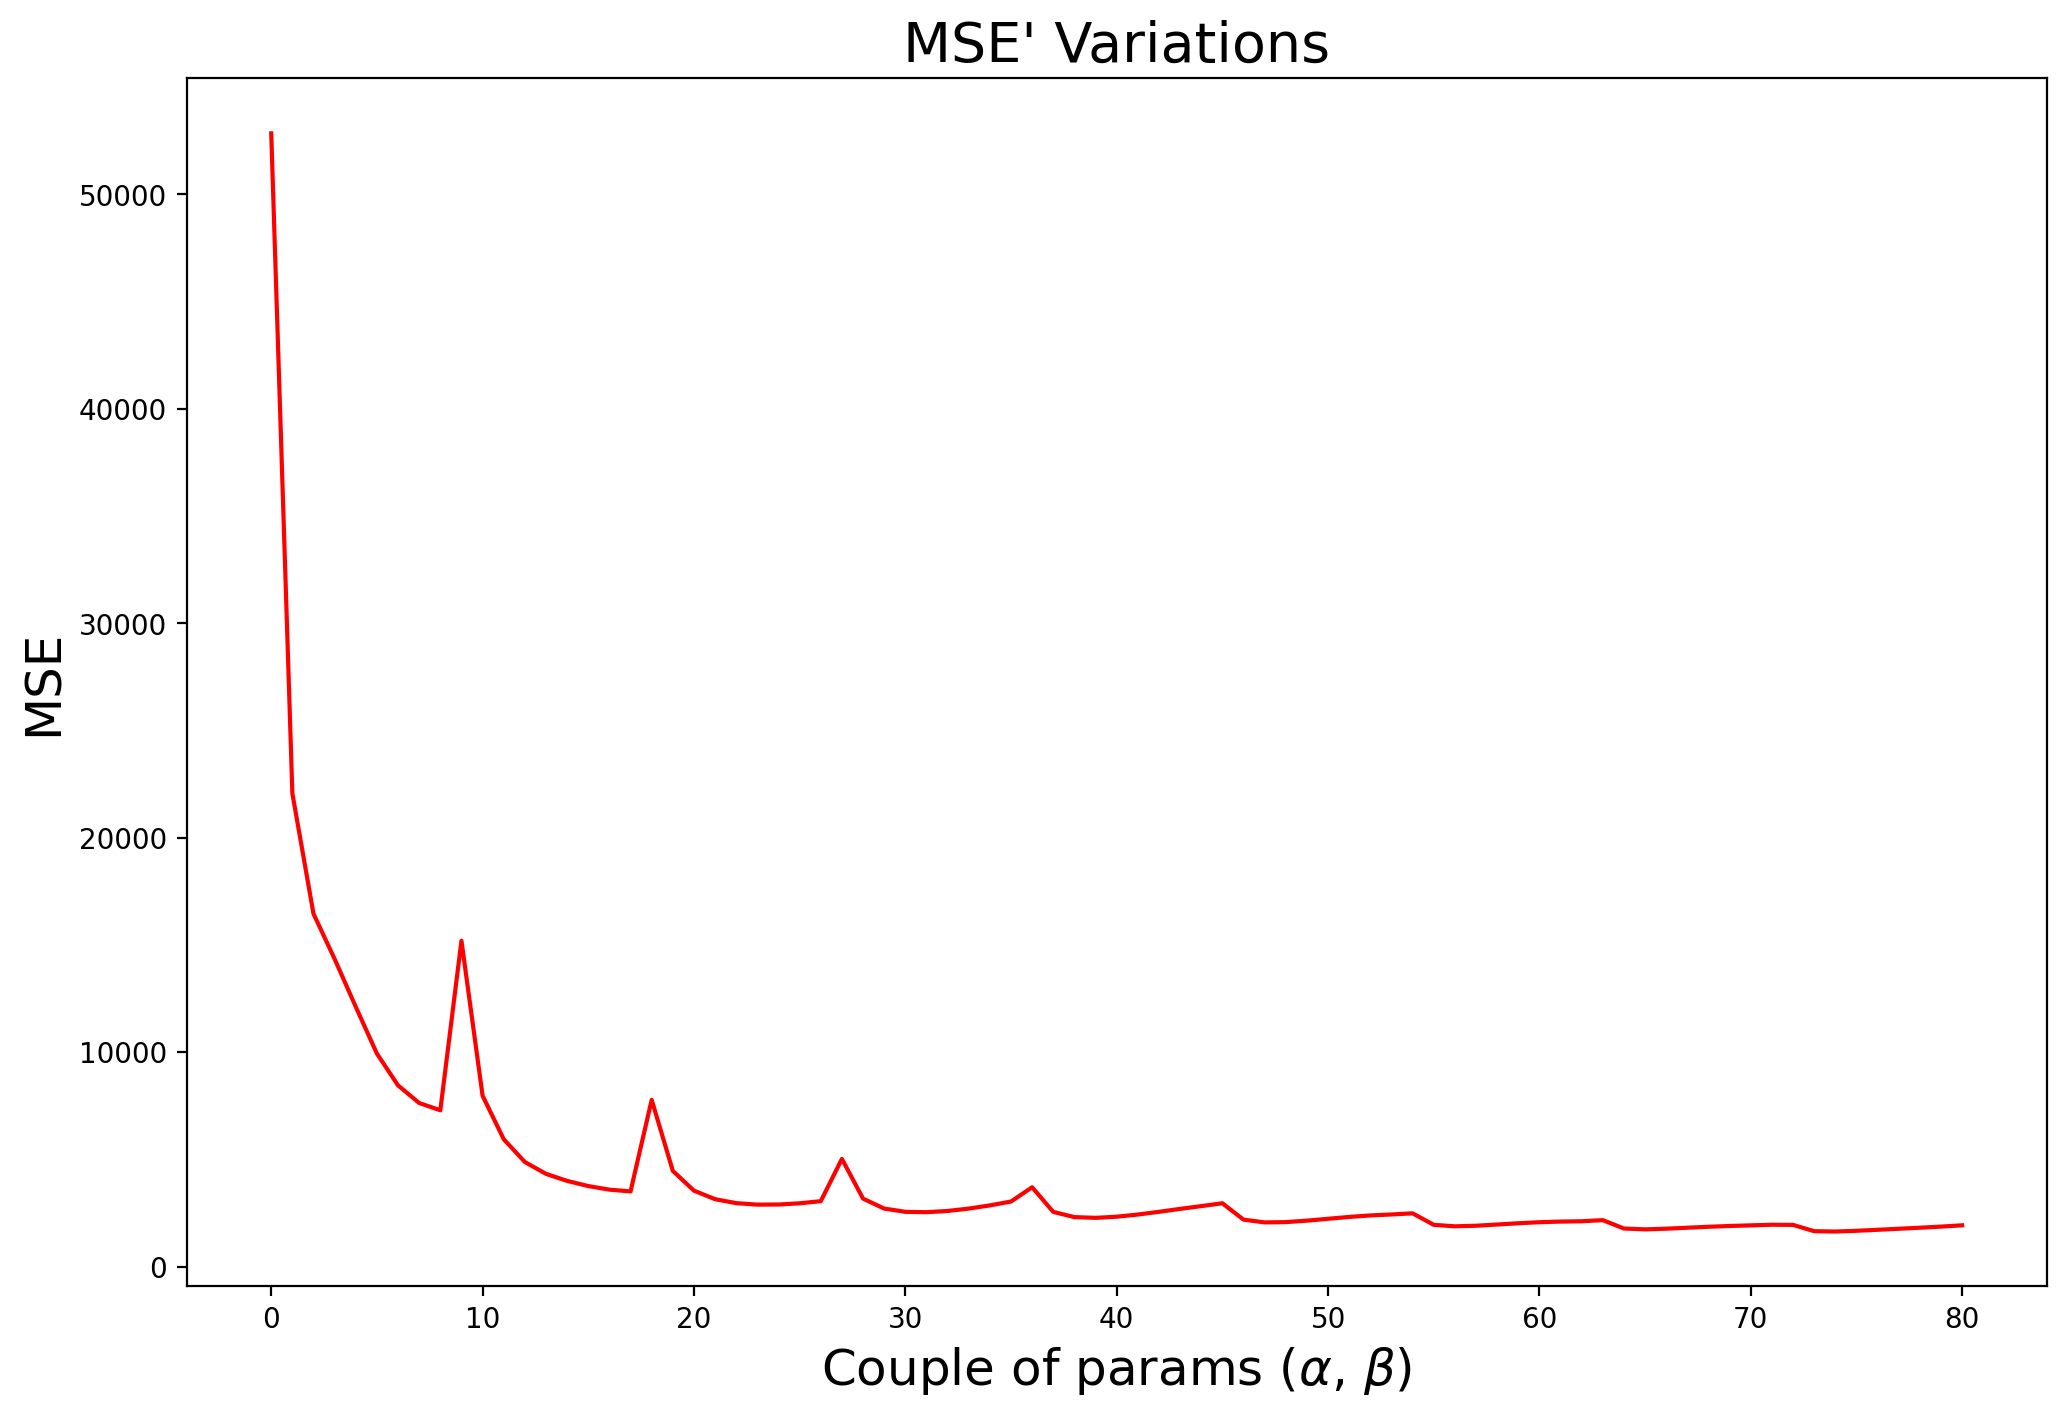

In [17]:
plt.figure(figsize=(12,8),dpi=200)
plt.plot(range(len(mse_list)), mse_list, 'r')
plt.xlabel("Couple of params ({0}, {1})".format(r'$ \alpha $', r'$ \beta $'), fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.title("MSE' Variations", fontsize=20)
plt.savefig("mse_tendance_lineaire.jpg")

In [18]:
len(mse_list)

81

Le MSE est 1634.66014717315
Les prévisions pour les 5 prochains jours sont:
366    34275.979620
367    34527.231934
368    34778.484248
369    35029.736563
370    35280.988877
Name: Additive trend, dtype: float64 


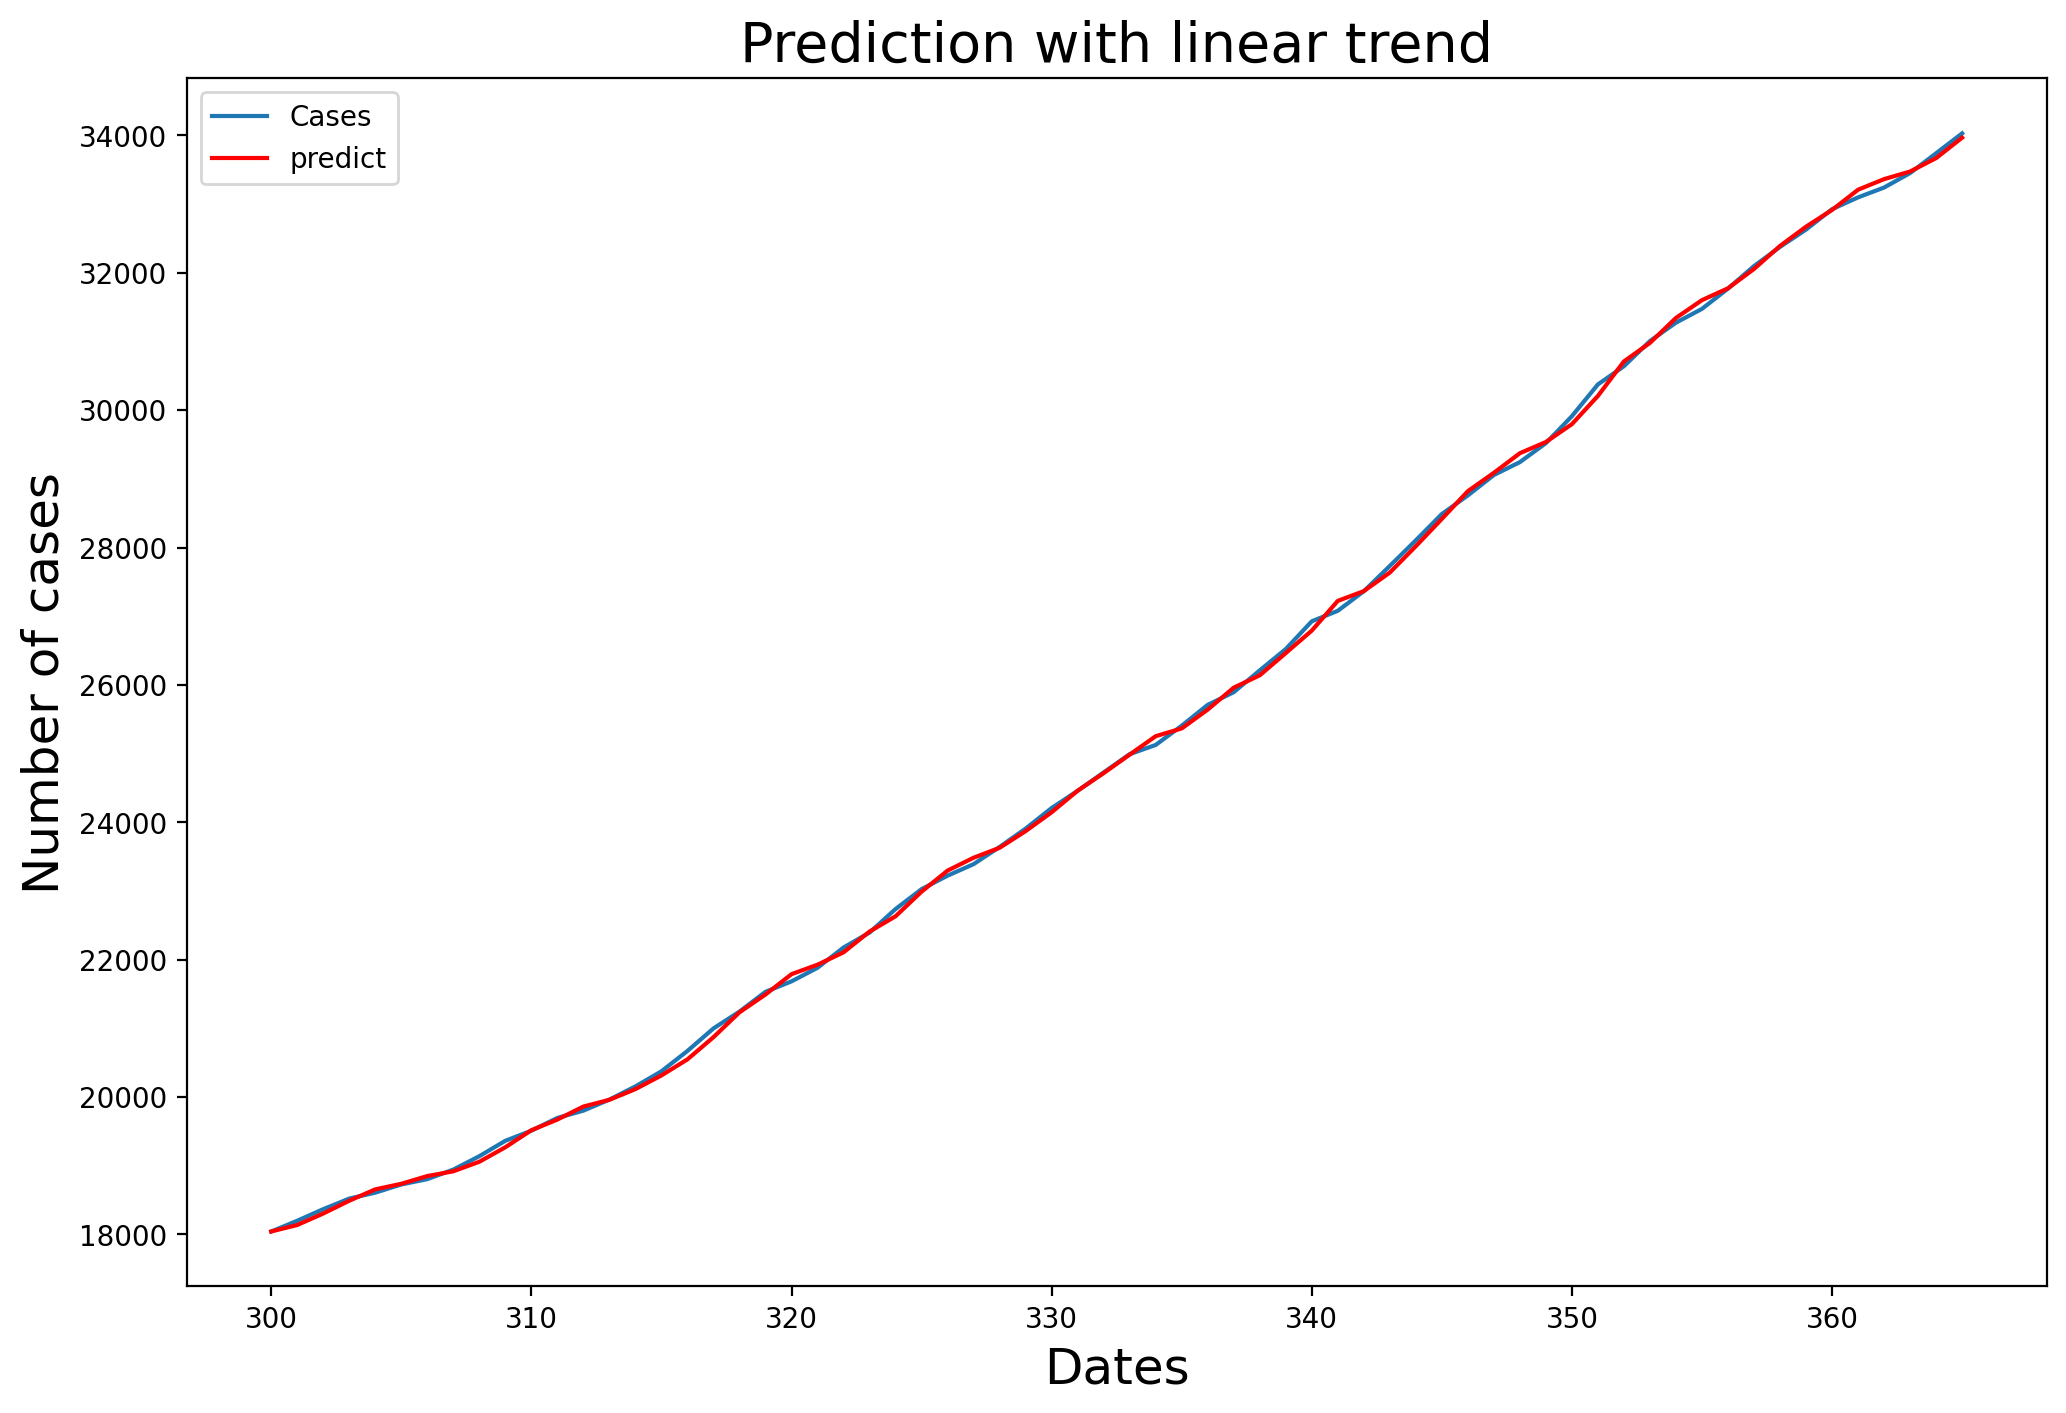

In [20]:
fit3 = Holt(data3).fit(smoothing_level=0.9, smoothing_slope=0.3)
#fcast3= fit3.forecast(5).rename("Exponential trend")
predicted=fit3.fittedvalues
error = mean_squared_error(data3, predicted)
print( 'Le MSE est {}'.format(error))

# Visualisation de la prévision
plt.figure(figsize=(12,8),dpi=200)
plt.plot(data3[300:], label="Cases") # la courbe des données réelles 
plt.plot(fit3.fittedvalues[300:], label="predict",color='red')# la courbe des données prédites
plt.legend()
plt.xlabel("Dates", fontsize=18)
plt.ylabel("Number of cases", fontsize=18)
plt.title("Prediction with linear trend", fontsize=20)
#plt.show ()
plt.savefig('Prediction_with_linear.jpg')

fcast3 = fit3.forecast(5).rename("Additive trend")
print( 'Les prévisions pour les 5 prochains jours sont:')
      
print('{} '.format(fcast3))



## Lissage de par la methode de Holt avec Tendance amortie 

In [21]:
value_poss=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
from sklearn.metrics import mean_squared_error
mse_list=[]
params=[]
for i in value_poss:
    for j in value_poss:
        fit3 = Holt(data3, damped=True).fit(smoothing_level=i, smoothing_slope=j)
        fcast3 = fit3.forecast(5).rename("Additive damped trend")
        predicted=fit3.fittedvalues
        error = mean_squared_error(data3, predicted)
        mse_list.append(error)
        params.append((i,j))
ind=mse_list.index(min(mse_list))
#print(mse_list[ind],params[ind])
print('Le MSE minimal est {0} et la valeur de alpha et beta correspondantes sont {1}'.format(mse_list[ind],params[ind]))
tmp=mse_list.copy()
tmp.sort()
for i in tmp[:10]:
    ind = mse_list.index(i)
    x = params[ind]
    print(x,i)

Le MSE minimal est 1661.5236276115331 et la valeur de alpha et beta correspondantes sont (0.9, 0.3)
(0.9, 0.3) 1661.5236276115331
(0.9, 0.4) 1679.3930299485592
(0.9, 0.5) 1714.8595662440728
(0.9, 0.2) 1720.7813700332442
(0.8, 0.3) 1747.619216485995
(0.9, 0.6) 1759.9453047285037
(0.8, 0.4) 1779.8756650461983
(0.9, 0.7) 1804.6964317324232
(0.8, 0.5) 1815.0086005038415
(0.9, 0.8) 1849.4772405199803


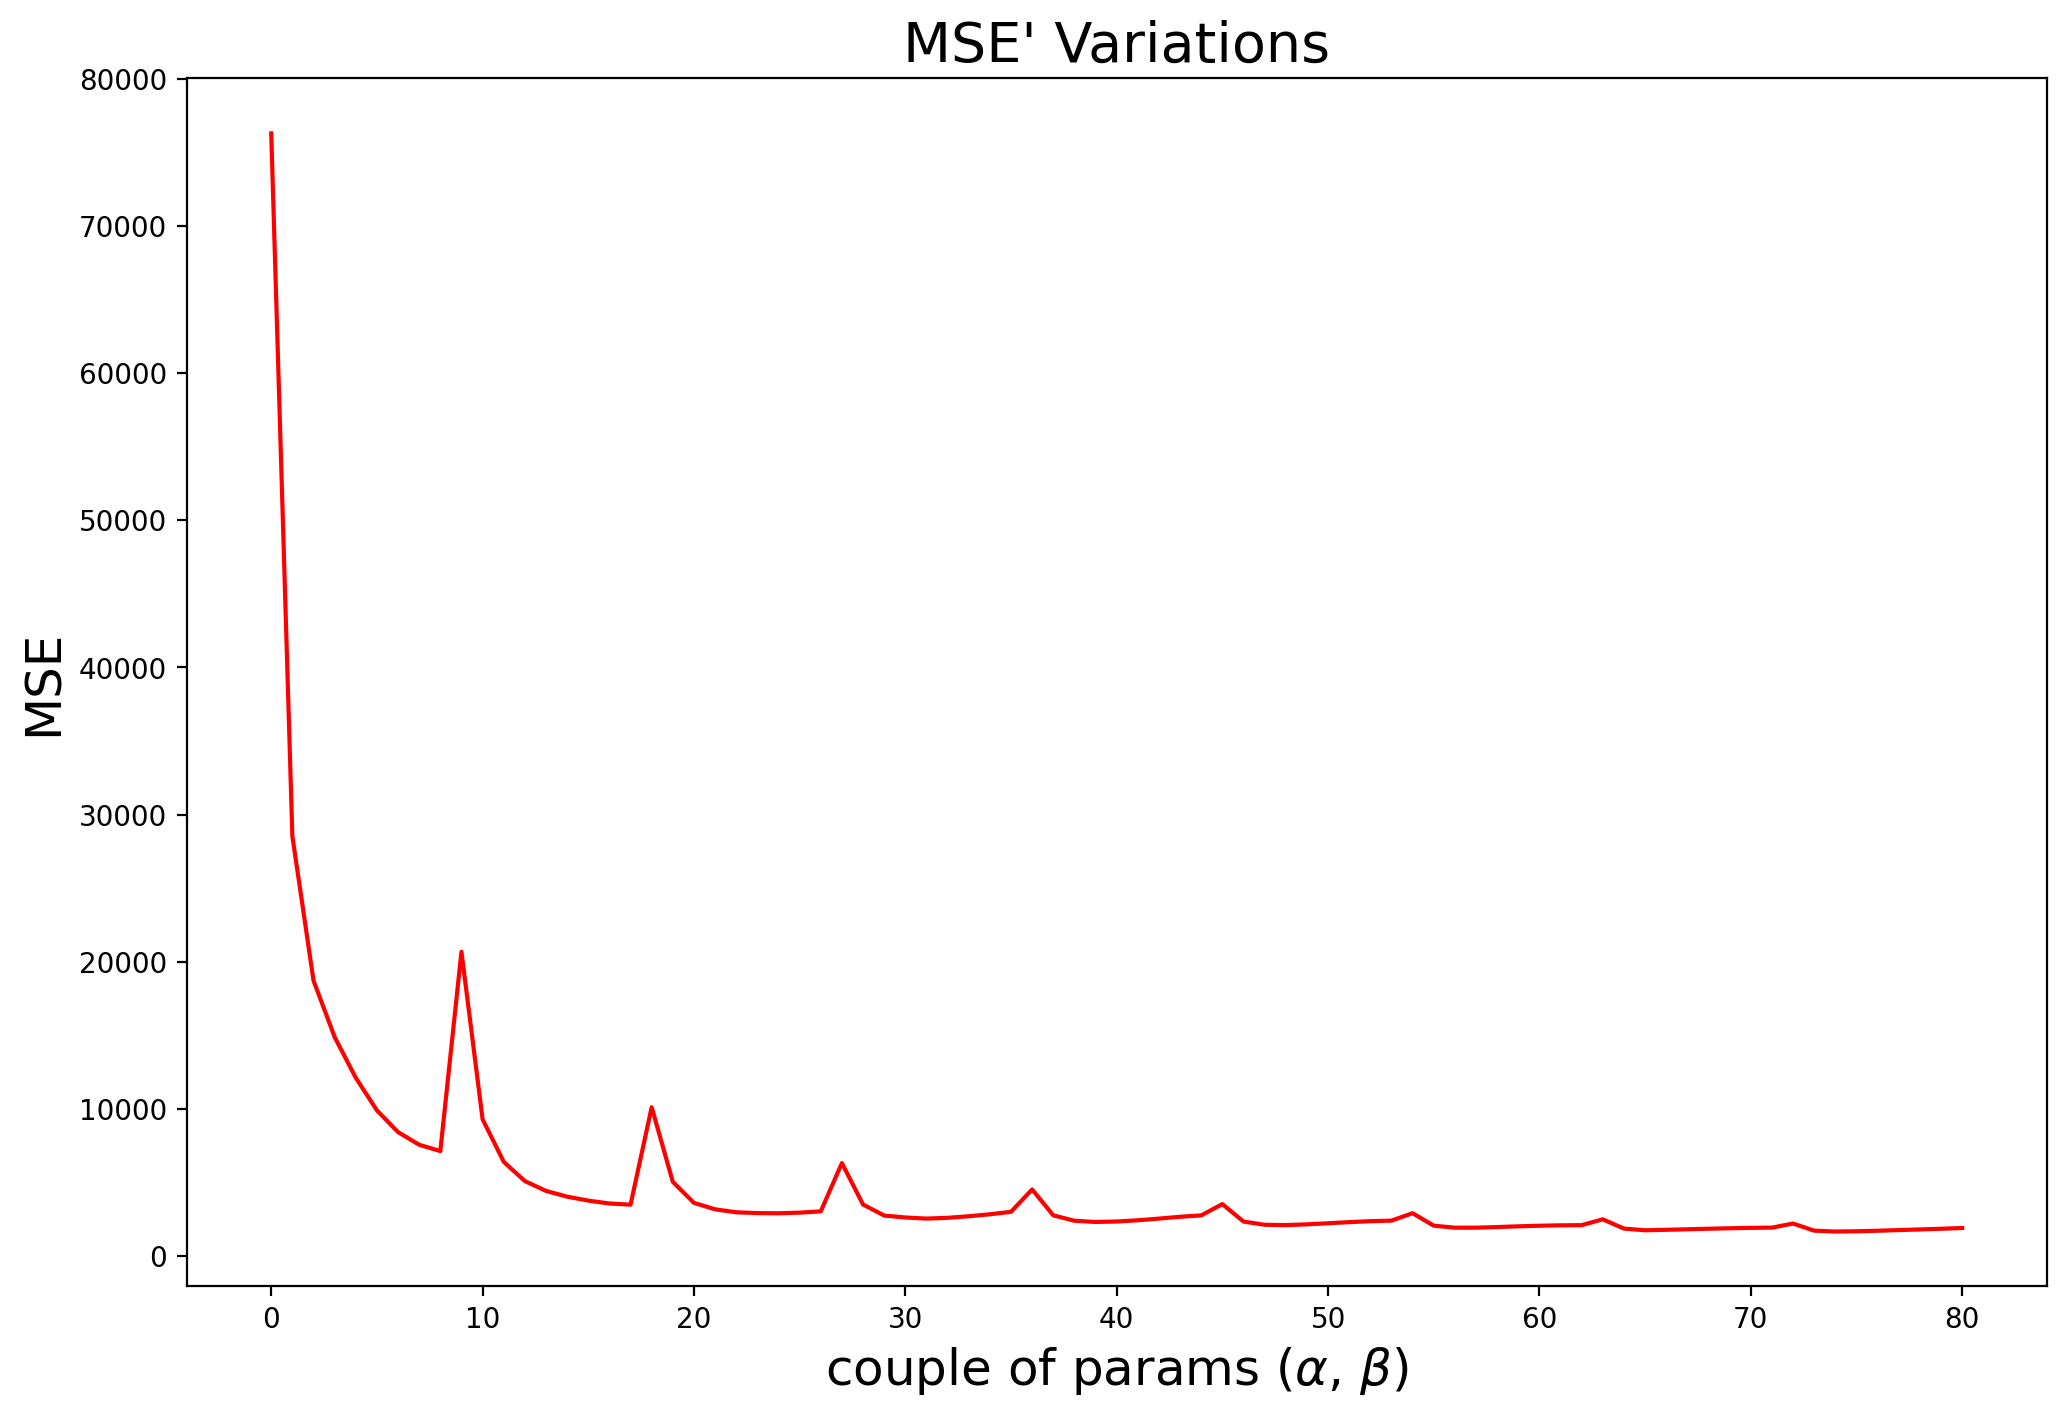

In [22]:
plt.figure(figsize=(12,8),dpi=200)
plt.plot(range(len(mse_list)), mse_list, 'r')
plt.xlabel("couple of params ({0}, {1})".format(r'$ \alpha $', r'$ \beta $'), fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.title("MSE' Variations", fontsize=20)
plt.savefig("mse_tendance_amorti.jpg")

Le MSE est 1661.5236276115331
Les prévisions pour les 5 prochains jours sont:
366    34267.122609
367    34507.964487
368    34746.397946
369    34982.447071
370    35216.135705
Name: trend amorti, dtype: float64 


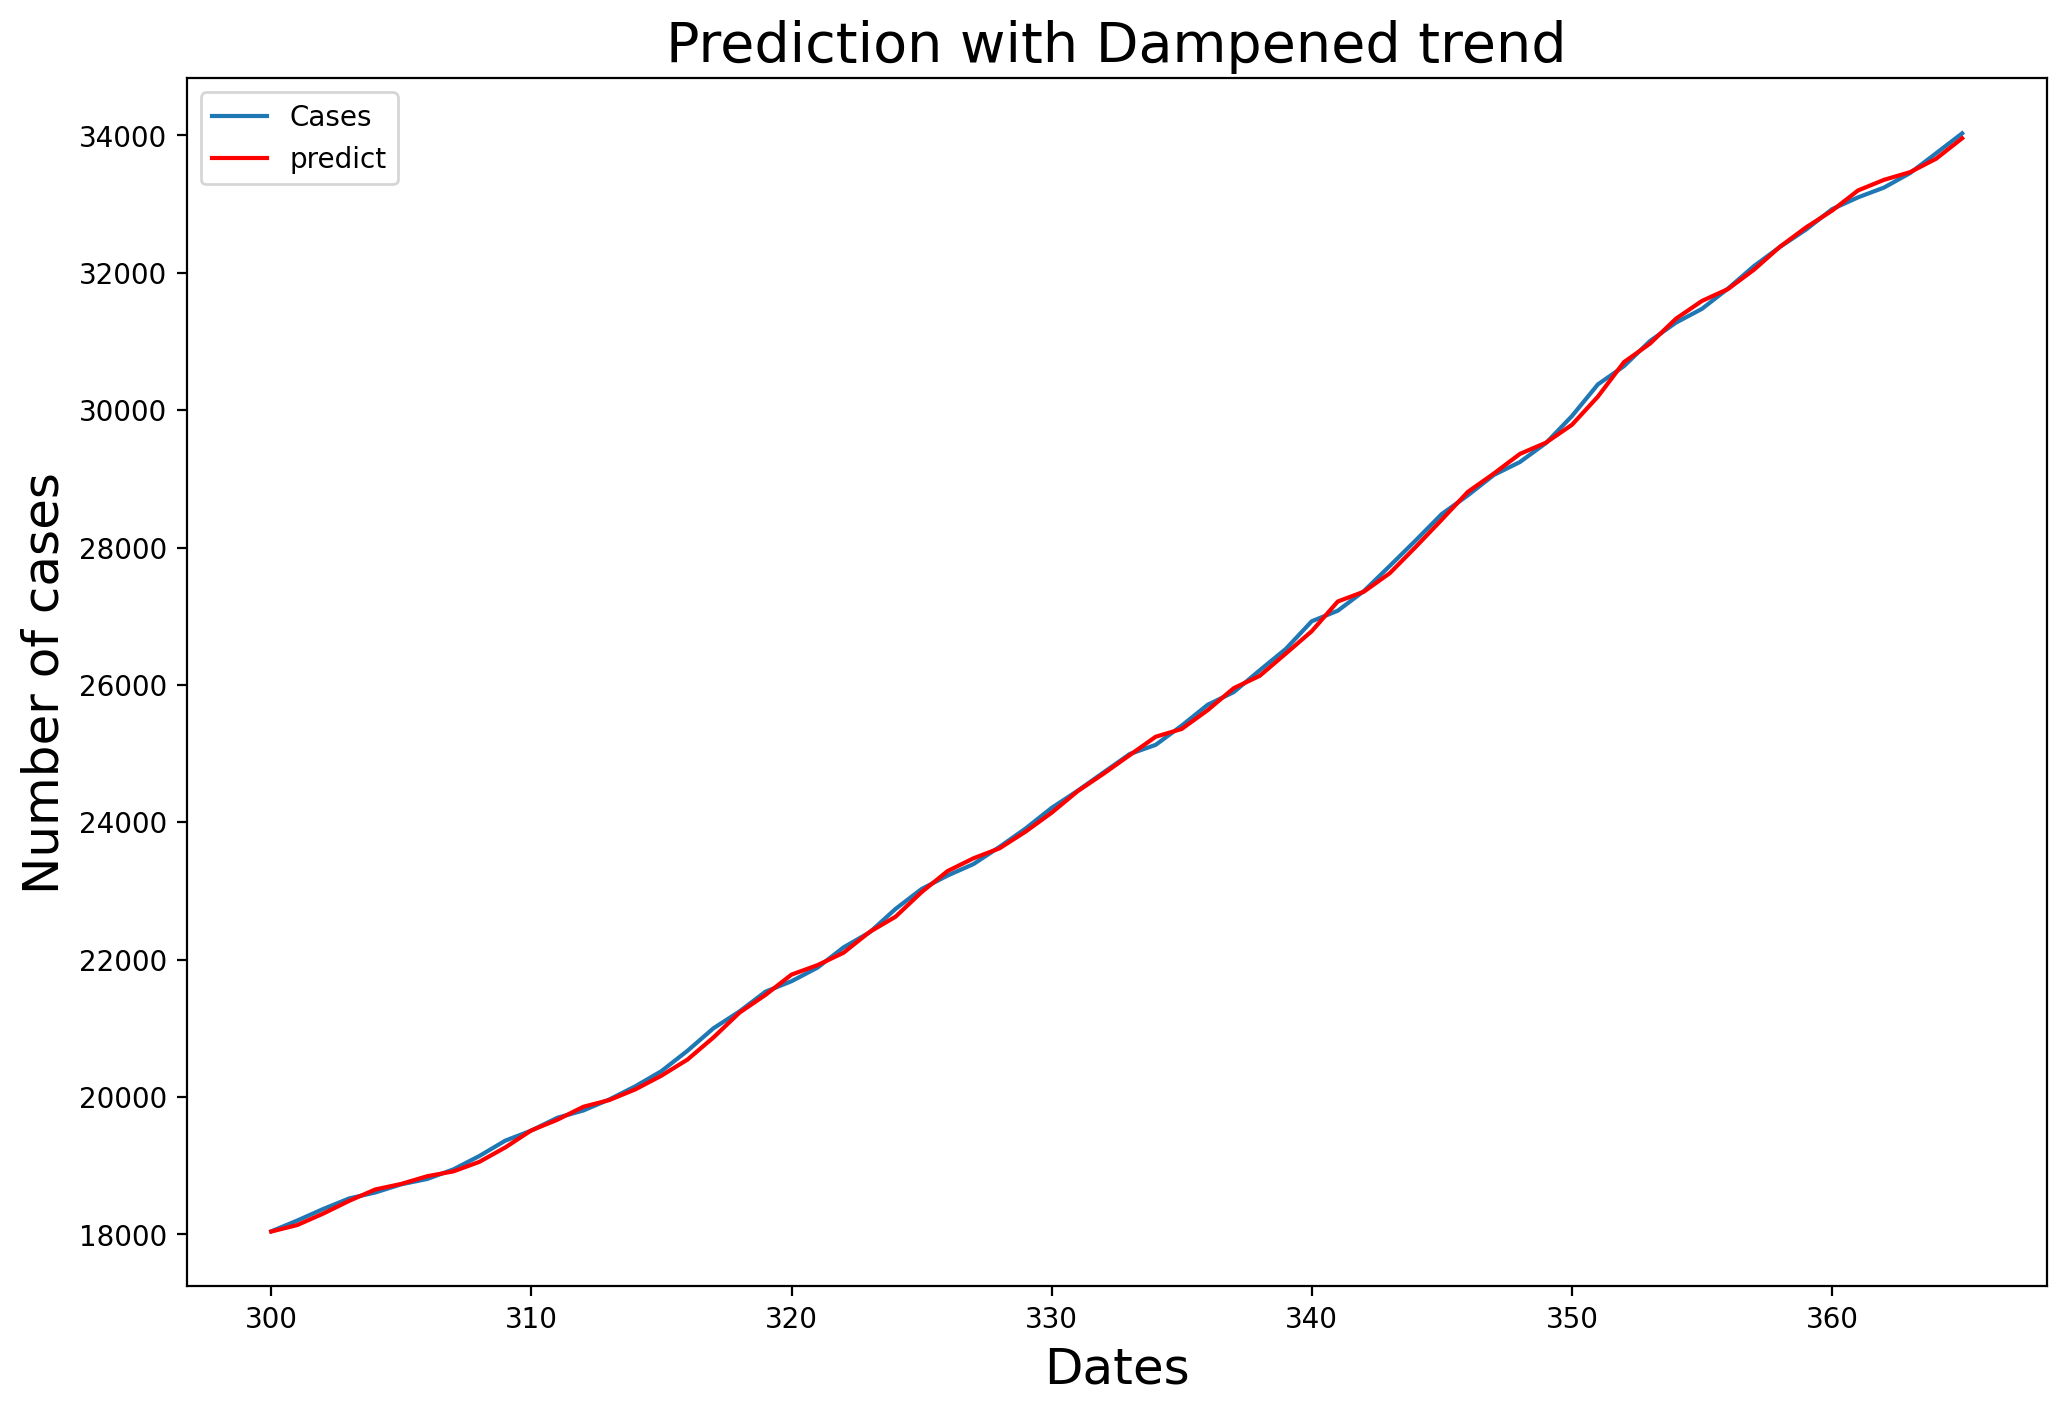

In [23]:
fit3 = Holt(data3, damped=True).fit(smoothing_level=0.9, smoothing_slope=0.3)
#fcast3= fit3.forecast(5).rename("Exponential trend")
predicted=fit3.fittedvalues
error = mean_squared_error(data3, predicted)
print( 'Le MSE est {}'.format(error))

# Visualisation de la prévision
plt.figure(figsize=(12,8),dpi=200)
plt.plot(data3[300:], label="Cases") # la courbe des données réelles 
plt.plot(fit3.fittedvalues[300:], label="predict",color='red')# la courbe des données prédites
plt.xlabel("Dates", fontsize=18)
plt.ylabel("Number of cases", fontsize=18)
plt.title("Prediction with Dampened trend", fontsize=20)
plt.legend()
#plt.show ()
plt.savefig("Prediction_with_dampened.jpg")
fcast3 = fit3.forecast(5).rename("trend amorti")
print( 'Les prévisions pour les 5 prochains jours sont:')
      
print('{} '.format(fcast3))

## Lissage de par la methode de Holt avec Tendance exponentielle

In [24]:
value_poss=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
from sklearn.metrics import mean_squared_error
mse_list=[]
params=[]
for i in value_poss:
    for j in value_poss:
        fit2 = Holt(data3[1:], exponential=True).fit(smoothing_level=i, smoothing_slope=j, optimized=False)
        #fcast2 = fit2.forecast(5).rename("Exponential trend")
        predicted=fit2.fittedvalues
        error = mean_squared_error(data3[1:], predicted)
        mse_list.append(error)
        params.append((i,j))
ind=mse_list.index(min(mse_list))
#print(mse_list[ind],params[ind])
print('Le MSE minimal est {0} et la valeur de alpha et beta correspondantes sont {1}'.format(mse_list[ind],params[ind]))
tmp=mse_list.copy()
tmp.sort()
inds = []
for i in tmp[:65]:
    ind = mse_list.index(i)
    inds.append(ind)
    #x = params[ind]
print(inds)

Le MSE minimal est 1694.1305358739908 et la valeur de alpha et beta correspondantes sont (0.9, 0.3)
[74, 75, 73, 76, 65, 77, 66, 78, 67, 64, 68, 79, 69, 56, 80, 57, 70, 71, 58, 55, 59, 60, 48, 61, 47, 62, 72, 49, 50, 46, 39, 51, 40, 38, 52, 63, 53, 41, 42, 31, 32, 30, 37, 43, 33, 54, 29, 44, 34, 24, 23, 25, 35, 26, 22, 21, 45, 28, 20, 17, 16, 15, 36, 14, 13]


In [25]:
inds.sort()

In [26]:
mse_exp = []
for i in inds:
    e = mse_list[i]
    mse_exp.append(e)

In [27]:
yy=mse_list.copy()
yy.sort()
aa=yy[:70]

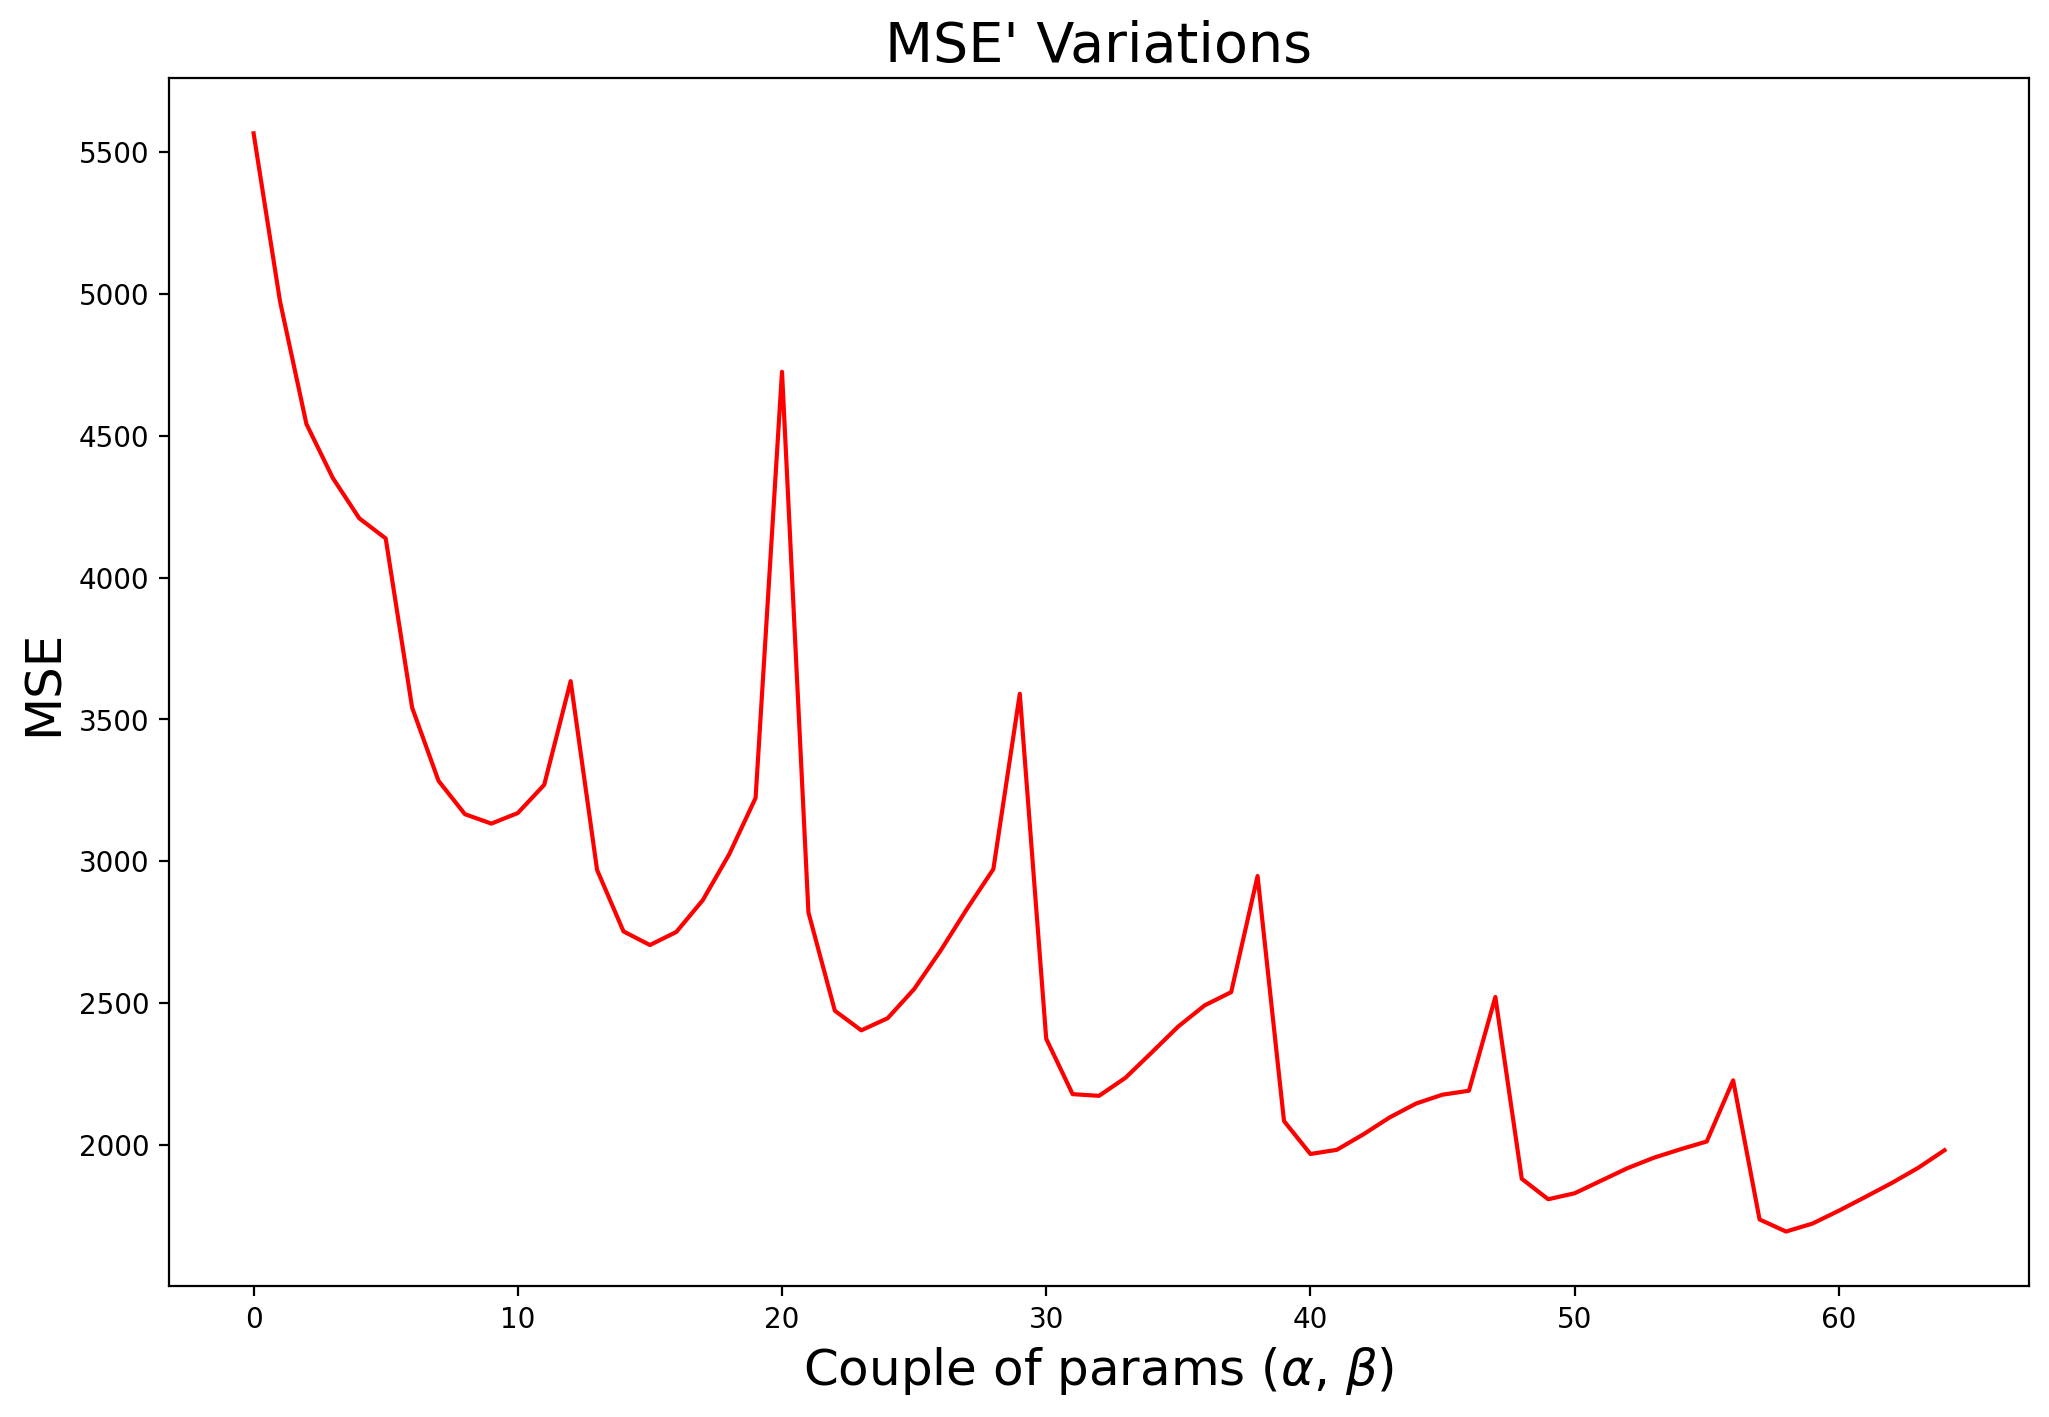

In [28]:
plt.figure(figsize=(12,8),dpi=200)
plt.plot(range(len(mse_exp)), mse_exp, 'r')
plt.xlabel("Couple of params ({0}, {1})".format(r'$ \alpha $', r'$ \beta $'), fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.title("MSE' Variations", fontsize=20)
plt.savefig("mse_tendance_exponentiel.jpg")

Le MSE est 1694.1305358739908
Les prévisions pour les 5 prochains jours sont:
366    34283.012259
367    34542.588479
368    34804.130100
369    35067.652001
370    35333.169176
Name: Exponential trend, dtype: float64 


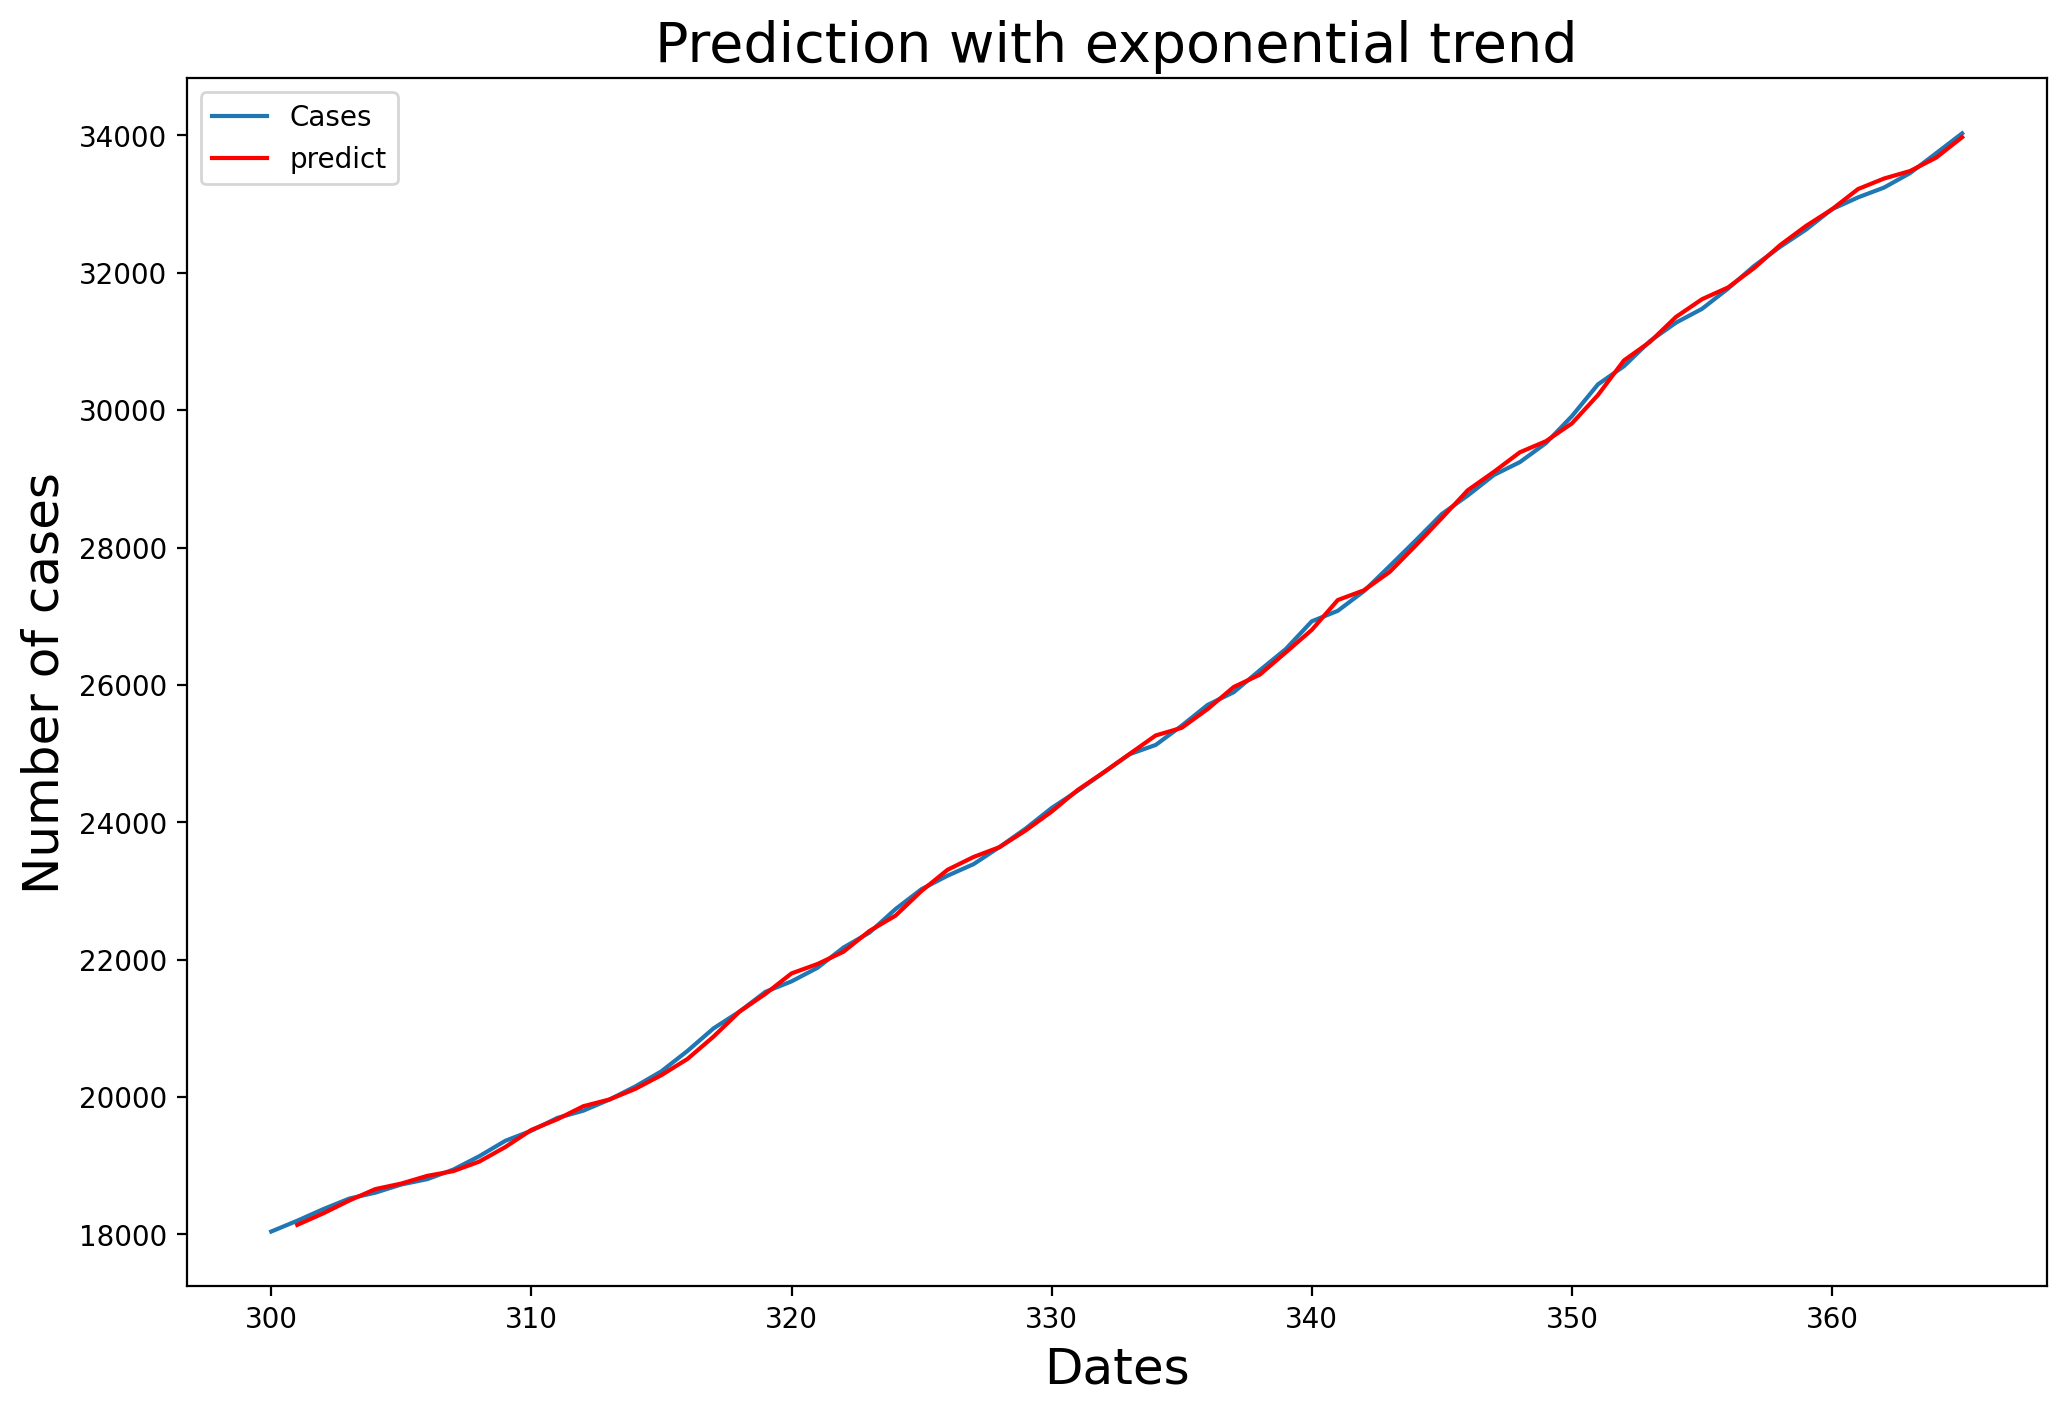

In [29]:
fit2 = Holt(data3[1:], exponential=True).fit(smoothing_level=0.9, smoothing_slope=0.3, optimized=False)
fcast2= fit2.forecast(5).rename("Exponential trend")
predicted=fit2.fittedvalues
error = mean_squared_error(data3[1:], predicted)
print( 'Le MSE est {}'.format(error))

# Visualisation de la prévision
plt.figure(figsize=(12,8),dpi=200)
plt.plot(data3[300:], label="Cases") # la courbe des données réelles 
plt.plot(fit2.fittedvalues[300:], label="predict",color='red')# la courbe des données prédites
plt.xlabel("Dates", fontsize=18)
plt.ylabel("Number of cases", fontsize=18)
plt.title("Prediction with exponential trend", fontsize=20)
plt.legend()
#plt.show ()

plt.savefig("Prediction_with_exp.jpg")
fcast2 = fit2.forecast(5).rename("Exponential trend")
print( 'Les prévisions pour les 5 prochains jours sont:')
      
print('{} '.format(fcast2))

In [30]:
len(predicted)

365